In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import numba
from numba import njit,jit
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])


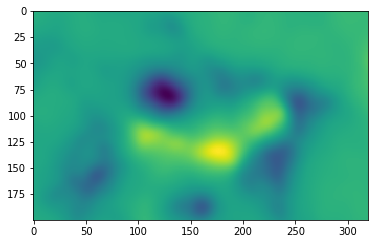

time: 4.16 s


In [3]:
a = sciIO.readsav('../B0.sav')
print(a.keys())
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0))
By = np.transpose(a.twbox[0].by,(2,1,0))
Bz = np.transpose(a.twbox[0].bz,(2,1,0))

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

plt.imshow(Bz[350:670,200:400,10].T) # x,y.z
#plt.imshow(Bz[:,:,0].T)

In [141]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
traceFunc =SourceModule(traceFunc_file.read(), include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = traceFunc.get_function("TraceAllBline")
print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = gpuarray.to_gpu(Bx.astype(np.float32))
    By_gpu = gpuarray.to_gpu(By.astype(np.float32))
    Bz_gpu = gpuarray.to_gpu(Bz.astype(np.float32))

compiling kernel
kernel compiled
time: 11.9 s


<ipython-input-141-0c570a84d529>:10: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(201): warning: variable "res" was set but never used

kernel.cu(212): warning: variable "P_b" was set but never used

kernel.cu

  traceFunc =SourceModule(traceFunc_file.read(), include_dirs=[PWD], cache_dir='cache',no_extern_c=True)


In [160]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = gpuarray.to_gpu(BshapeN)

interp_ratio=4
x_range = [0,1163]
y_range = [0,487]
x_range = [350,670]
y_range = [200,400]
x_i = np.linspace(*x_range, np.uint32(interp_ratio*(x_range[1]-x_range[0])))
y_i = np.linspace(*y_range, np.uint32(interp_ratio*(y_range[1]-y_range[0])))
x_arr,y_arr = np.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten().astype(np.float32)
y_inp = y_arr.flatten().astype(np.float32)
z_inp = (np.zeros_like(x_inp)+23.583333).astype(np.float32)
#z_inp[:] = 23.0

(x_start,y_start,z_start, x_end,y_end,z_end,
 Bx_start,By_start,Bz_start,  Bx_end,By_end,Bz_end,   Bx_inp,By_inp,Bz_inp
)=[gpuarray.to_gpu(np.zeros_like(x_inp).astype(np.float32)) for _ in range(15)]

flag_start=flag_end=gpuarray.to_gpu(np.zeros_like(x_inp).astype(np.int32))

line_len = gpuarray.to_gpu(np.zeros_like(x_inp).astype(np.float64))
N        = gpuarray.to_gpu(np.ulonglong([x_inp.shape[0]]))
s_len    = gpuarray.to_gpu(np.float32([1./8.]))

x_inp = gpuarray.to_gpu(x_inp)
y_inp = gpuarray.to_gpu(y_inp)
z_inp = gpuarray.to_gpu(z_inp)

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)


[1164  488  488]
time: 242 ms


In [161]:
# run the big calclation
TraceAllBline(Bx_gpu,By_gpu,Bz_gpu,BshapeN,
            x_inp,y_inp,z_inp,
            x_start, y_start, z_start, flag_start,
            x_end,   y_end,   z_end,   flag_end,
            Bx_inp,  By_inp,  Bz_inp,
            Bx_start,By_start,Bz_start,
            Bx_end,  By_end,  Bz_end,  
            s_len,N,line_len,block=blck,grid=grd)

pycuda.driver.Context.synchronize()

time: 2.06 s


In [171]:
x_end_arr = x_end.get().reshape(xy_shape).astype(np.float64)
y_end_arr = y_end.get().reshape(xy_shape).astype(np.float64)

x_start_arr = x_start.get().reshape(xy_shape).astype(np.float64)
y_start_arr = y_start.get().reshape(xy_shape).astype(np.float64)

flags_arr = flag_end.get().reshape(xy_shape).astype(np.float64)
Bz_arr_in_z = Bz_start.get().reshape(xy_shape).astype(np.float64)
Bz_arr_out_z = Bz_end.get().reshape(xy_shape).astype(np.float64)

Bz_arr_0_z = Bz_inp.get().reshape(xy_shape).astype(np.float64)

dx2xc = x_end_arr[2:,1:-1]-x_end_arr[0:-2,1:-1];
dx2yc = x_end_arr[1:-1,2:]-x_end_arr[1:-1,0:-2];
dy2xc = y_end_arr[2:,1:-1]-y_end_arr[0:-2,1:-1];
dy2yc = y_end_arr[1:-1,2:]-y_end_arr[1:-1,0:-2];

dx1xc = x_start_arr[2:,1:-1]-x_start_arr[0:-2,1:-1];
dx1yc = x_start_arr[1:-1,2:]-x_start_arr[1:-1,0:-2];
dy1xc = y_start_arr[2:,1:-1]-y_start_arr[0:-2,1:-1];
dy1yc = y_start_arr[1:-1,2:]-y_start_arr[1:-1,0:-2];

a = (dx2xc*dy1yc-dx2yc*dy1xc);
b = (dx2yc*dx1xc-dx2xc*dx1yc);
c = (dy2xc*dy1yc-dy2yc*dy1xc);
d = (dy2yc*dx1xc-dy2xc*dx1yc);

bnr = np.abs(Bz_arr_in_z[1:-1,1:-1]*Bz_arr_out_z[1:-1,1:-1])/(np.abs(Bz_arr_0_z[1:-1,1:-1])**2)*((interp_ratio/2)**4)

Q = (a**2+b**2+c**2+d**2)*bnr
Q[np.where(Q<1.0)]=1.0


time: 330 ms


Text(0.5, 1.0, 'Length histogram')

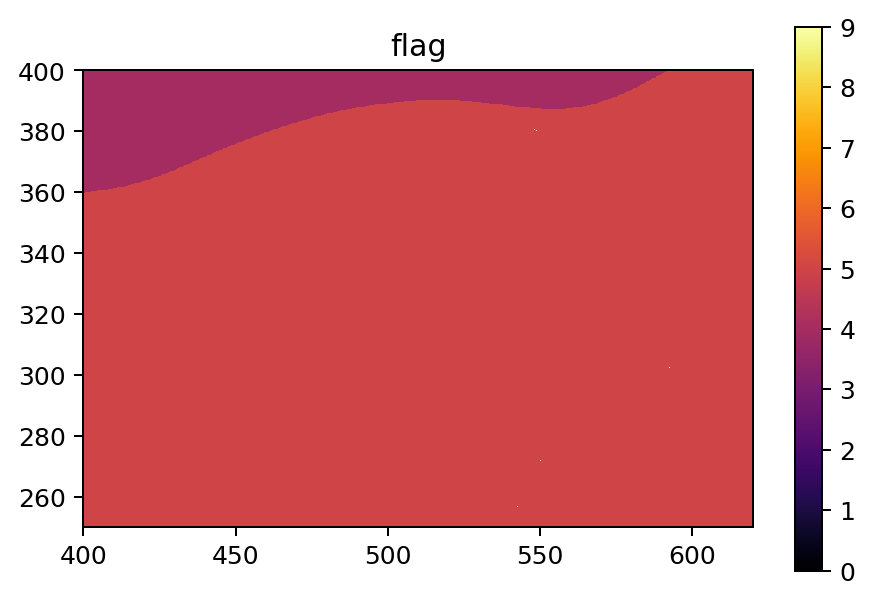

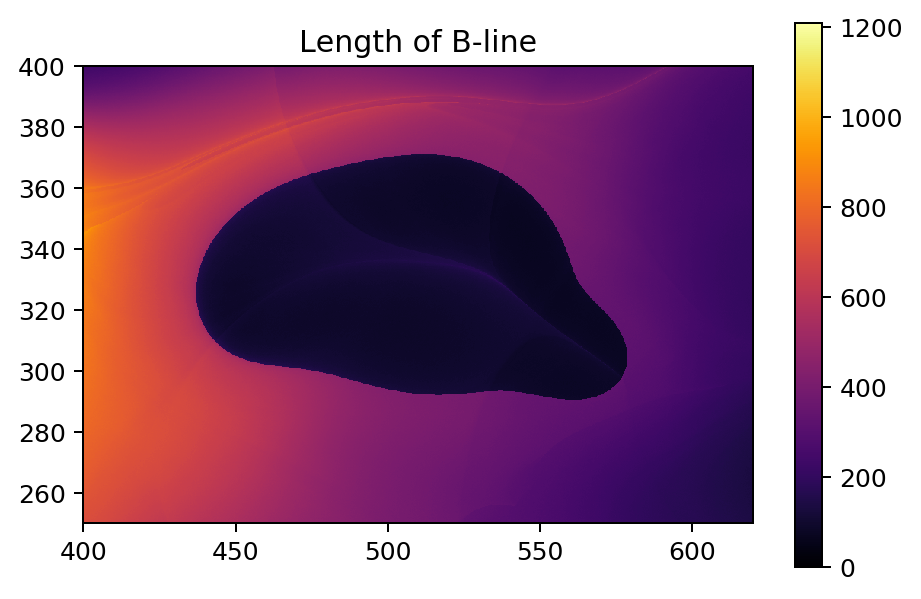

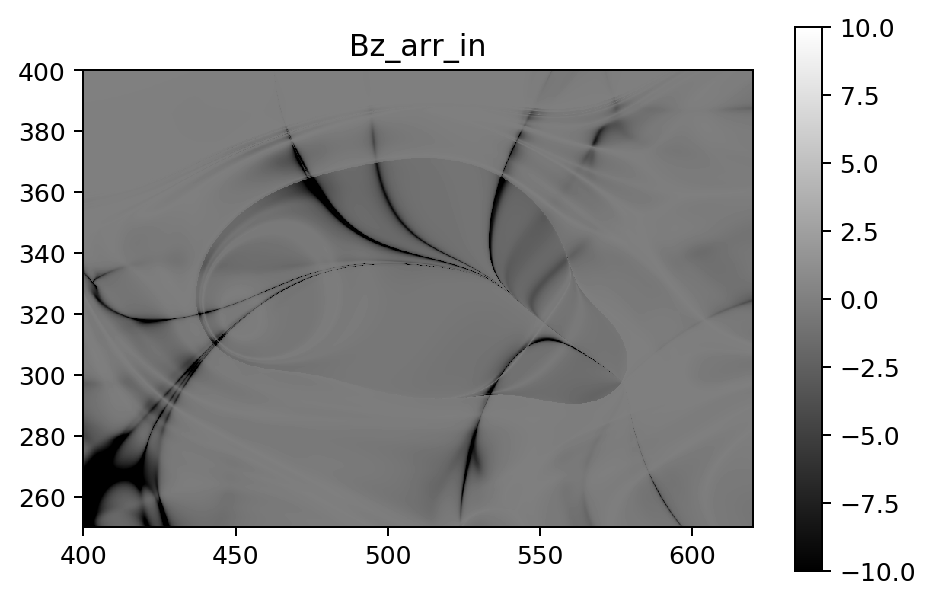

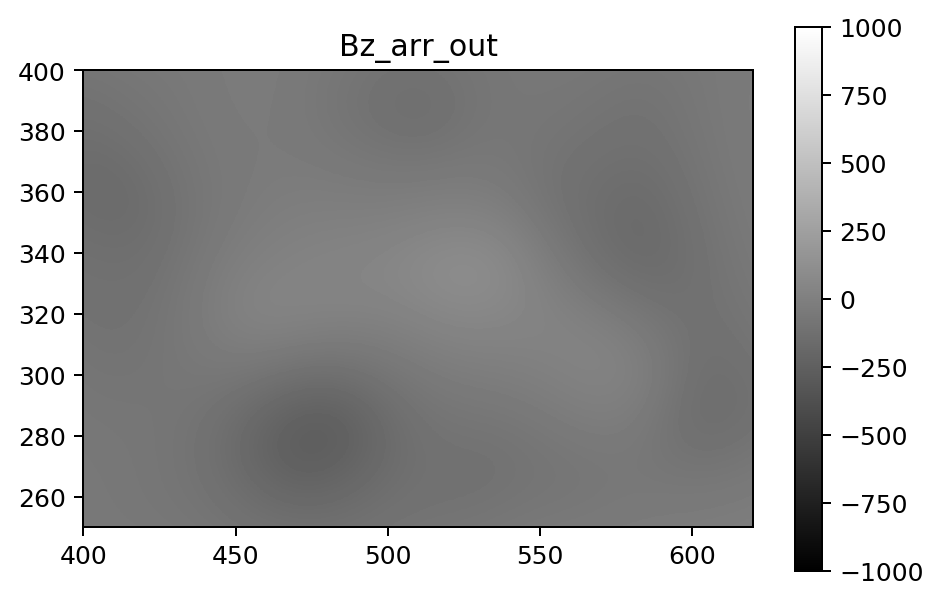

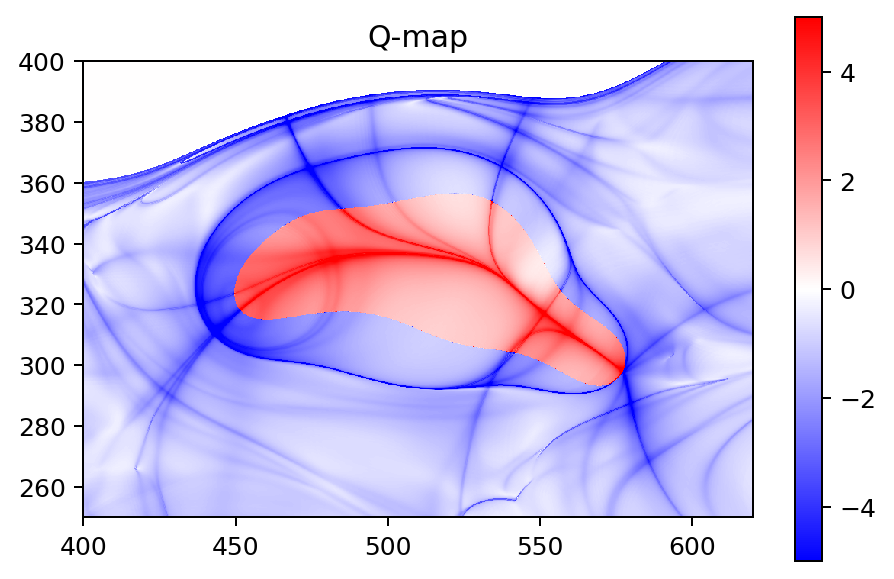

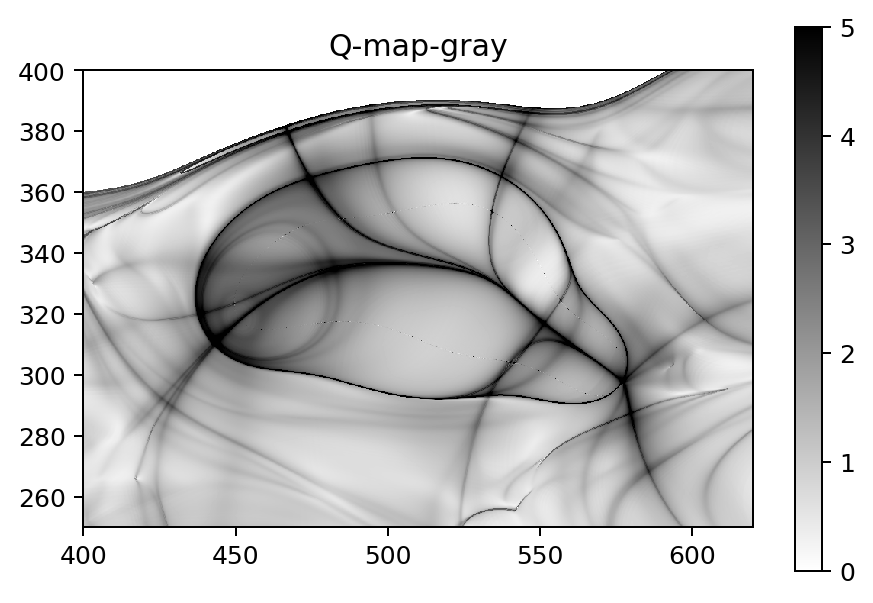

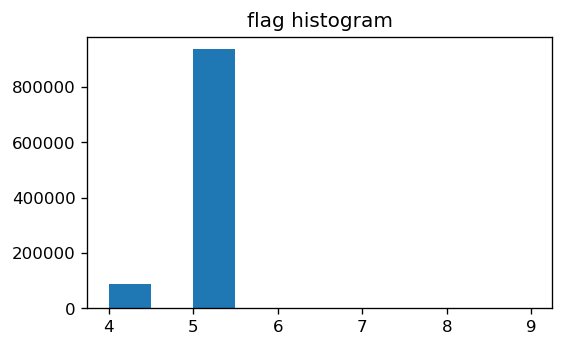

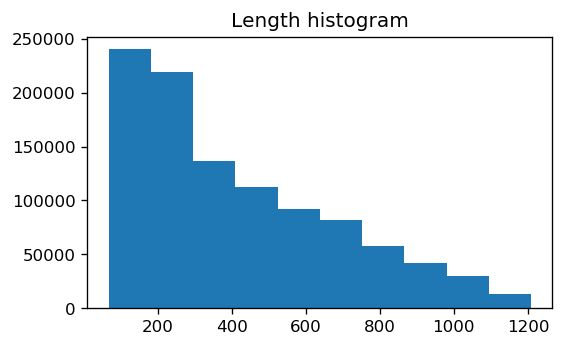

time: 3.44 s


In [174]:
plt.close()

xxlim=[400,620]
yylim=[250,400]
dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flags_arr,cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow(line_len.get().reshape(xy_shape),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_arr_in_z/Bz_arr_out_z,cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_arr_0_z,cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q)*np.sign(Bz_arr_0_z[1:-1,1:-1])*(flags_arr[1:-1,1:-1]==5),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


fig=plt.figure(5,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q)*(flags_arr[1:-1,1:-1]==5),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


plt.figure(10,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(flag_end.get())
ax.set_title('flag histogram')

plt.figure(11,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(line_len.get())
ax.set_title('Length histogram')


(200.0, 400.0)

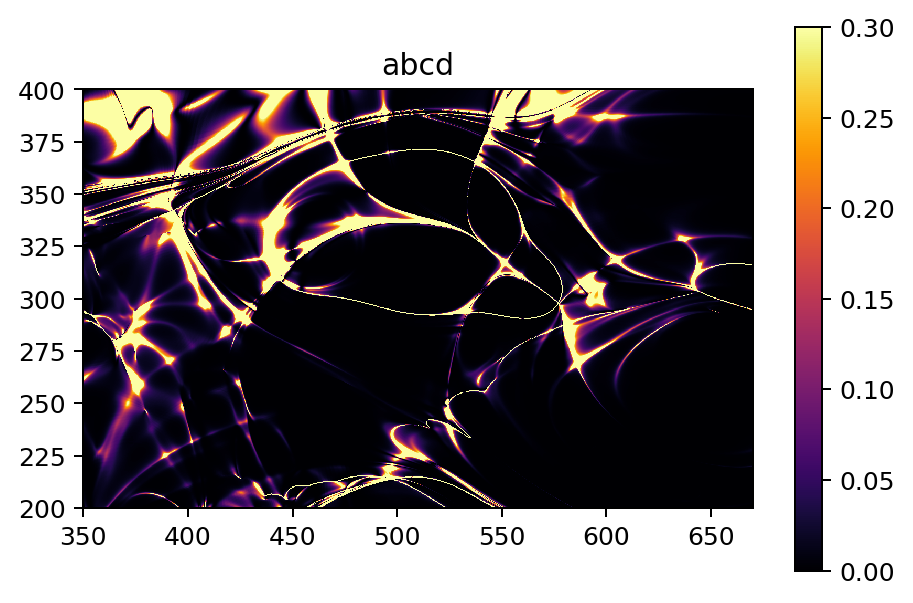

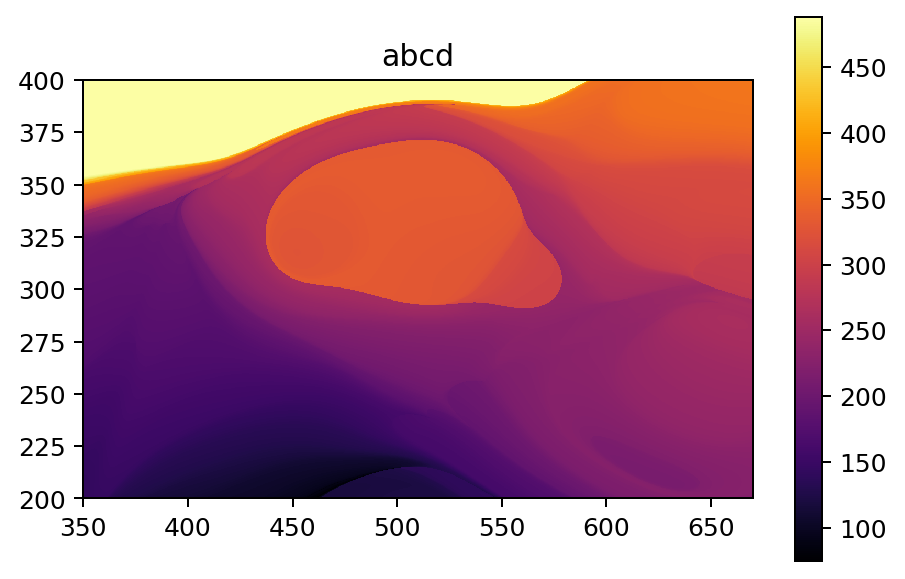

time: 994 ms


In [170]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
img = ax.imshow(d**2,cmap='inferno',origin='lower',vmax=0.3,vmin=0,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=180); ax = plt.gca() 
img = ax.imshow(y_start_arr,cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


In [175]:
print("\n".join("   ".join([str(i) for i in range(5)])))

0
 
 
 
1
 
 
 
2
 
 
 
3
 
 
 
4
time: 3.02 ms
